In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

## Read in netCDF data

In [3]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7f1ed8000970>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d1e20>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d1e50>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d1ee0>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d1f70>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d8070>,
 'nv': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d8100>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d8190>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d82b0>,
 'lat_bnds': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d8310>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d83a0>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d8460>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d84c0>,
 'tpa_correction': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d8550>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7f1eaf8d85e0>,
 'longitude': <scipy.io._n

In [5]:
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_x = f.variables['ugos'].data.squeeze()
print(vel_x.shape[0])
vel_y = f.variables['vgos'].data.squeeze()
print(vel_y.shape)
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)[60:82,10:40]
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)[60:82,10:40]

321
(321, 81)


In [172]:
xlim = (-20, 20)
ylim = (-20, 20)

x = np.linspace(*xlim, num=50)
y = np.linspace(*ylim, num=50)

xx, yy = np.meshgrid(x, y, indexing='xy')

def vort_x(x, y):
    return (-y)/(1 + x**2 + y**2)

def vort_y(x, y):
    return (x)/(1 + x**2 + y**2)

imputed_vel_x = vort_x(xx - 10,yy) + vort_x(xx + 10,yy) - vort_x(xx,yy-10) + vort_x(xx,yy+10)
imputed_vel_y = vort_y(xx - 10,yy) + vort_y(xx + 10,yy) - vort_y(xx,yy-10) + vort_y(xx,yy+10)


0.19557479515228343
1.9720821575750596


<IPython.core.display.Javascript object>


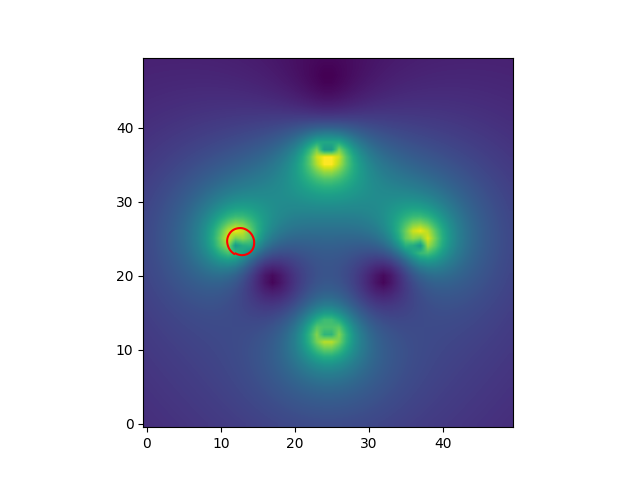

In [180]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.spatial.distance import euclidean


# first build an interpolator over the x and y velocity
# for now dont use any proper coordinates just [0,m]*[0,n]
m,n = imputed_vel_x.shape
x = np.linspace(0, n, n)
y = np.linspace(0, m, m)
method = "linear"

interp_vel_x = RegularGridInterpolator((x, y), imputed_vel_x.T, method=method)
interp_vel_y = RegularGridInterpolator((x, y), imputed_vel_y.T, method=method)

def rhs(t, x):
    return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    
def streamline(i,j, steps, step_size):
    winding_angle = 0
    theta_prev = 0
    
    start_i = i
    start_j = j
    
    trajectory = [[i,j]]
    
    for k in range(steps):
        try:
            v = rhs(0,[i,j])
        except:
            break
        
        # integrate
        i += step_size*v[0]
        j += step_size*v[1]
        
        theta = np.arctan2(v[1],v[0])

        if k > 200:
            winding_angle += theta - theta_prev
            
            if euclidean([i,j],[start_i,start_j]) < 0.2:
                print(euclidean([i,j],[start_i,start_j]))
                break
            
            
        theta_prev = theta
        trajectory.append([i,j])
    
    print(winding_angle % (2*np.pi))
    
    return np.asarray(trajectory).T
        
        
        
        

sol = streamline(12,23, 2000, 0.1)

plt.figure()
plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y), origin='lower', interpolation="bilinear")
plt.plot(sol[0], sol[1], 'r-')

In [119]:
sol.T[0]

array([1.00000000e+01, 3.65909091e-03, 1.00419904e+00, ...,
       9.97000000e+02, 9.98000000e+02, 9.99000000e+02])